In [17]:
import pandas as pd
import numpy as np
import parameters as P
import sensitivity_parameters as SP
import helper_functions as hf

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
io_data = pd.read_csv(P.io_table_dollars_path)

In [20]:
cost = hf.csv_dict_list(P.cost_impact_path)

In [21]:
y = {}
for item in cost.keys():
    y.update({item:0})

In [22]:
m = {} 
for scenario in P.scenario_range:
    new_data = np.zeros([7,3])
    m[scenario] = pd.DataFrame(new_data, columns=P.selectivity, index=P.processes)

In [23]:
for selectivity in P.selectivity:
    for scenario in P.scenario_range:
        if (selectivity == "waterwash"): 
            y["lysine.us.kg"] = cost["lysine.us.kg"] * SP.other_params[selectivity]['chlys_amount'][scenario] * 0.58 
            # 58% lysine + 42% ChOH for Chylys production (Stoichiometry) 
            y["cholinium.hydroxide.kg"] = (cost["cholinium.hydroxide.kg"] * 
                                           SP.other_params[selectivity]['chlys_amount'][scenario] * 0.42)  
            # 58% lysine + 42% ChOH for Chylys production (Stoichiometry) 
            y["cellulase.kg"] = cost["cellulase.kg"] * SP.common_params['enzyme'][scenario]
            y["csl.kg"] = cost["csl.kg"] * 0.06
            y["farmedstover.kg"] = cost["farmedstover.kg"] * SP.other_params[selectivity]['feedstock'][scenario]  
            y["dap.kg"] = cost["dap.kg"] * 0.01
            y["h2so4.kg"] = cost["h2so4.kg"] * 0.002
            y["naturalgas.MJ"] = cost["naturalgas.MJ"] * (hf.FuelConvertMJ(
                    SP.other_params[selectivity]['ng_input_stream_mass_ww_kg'][scenario], "naturalgas","kg"))
            y["rail.mt_km"] = (cost["rail.mt_km"] * (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 100 * 1.6 +
                                  cost["rail.mt_km"] * (
                                    P.etoh_feed_stream_mass_kg/1000 * SP.common_params['etoh_distribution_rail'][scenario])) 
            y["flatbedtruck.mt_km"] = (cost["flatbedtruck.mt_km"] * (
                    (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 50 * 1.6) +
                    cost["flatbedtruck.mt_km"] * (P.etoh_feed_stream_mass_kg/1000 * (
                    SP.common_params['etoh_distribution_truck'][scenario])))
            y["electricity.{}.kWh".format(P.facility_electricity)] = (
                cost["electricity.{}.kWh".format(P.facility_electricity)] * (
                    SP.other_params[selectivity]['electricity_requirements'][scenario]))

            biorefinery_direct_ghg = hf.FuelCO2kg(hf.FuelConvertMJ(
                    SP.other_params[selectivity]['ng_input_stream_mass_ww_kg'][scenario],"naturalgas","kg"), "naturalgas")
            
        
        if (selectivity == "iHG-Projected"):
            y["lysine.us.kg"] = cost["lysine.us.kg"] * SP.other_params[selectivity]['chlys_amount'][scenario] * 0.58 
            # 55% lysine + 45% ChOH for Chylys production (assumption) 
            y["cholinium.hydroxide.kg"] = (cost["cholinium.hydroxide.kg"] * 
                                           SP.other_params[selectivity]['chlys_amount'][scenario] * 0.42)  
            # 50% lysine + 50% ChOH for Chylys production (assumption) 
            y["cellulase.kg"] = cost["cellulase.kg"] * SP.common_params['enzyme'][scenario]
            y["csl.kg"] = cost["csl.kg"] * 0.05
            y["farmedstover.kg"] = cost["farmedstover.kg"] * SP.other_params[selectivity]['feedstock'][scenario]
            y["dap.kg"] = cost["dap.kg"] * 0.017  
            y["rail.mt_km"] = (cost["rail.mt_km"] * (
                (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 100 * 1.6) +
                               cost["rail.mt_km"] * (
                P.etoh_feed_stream_mass_kg/1000 * SP.common_params['etoh_distribution_rail'][scenario]))
            y["flatbedtruck.mt_km"] = (cost["flatbedtruck.mt_km"] * (
                (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 50 * 1.6) +
                    cost["flatbedtruck.mt_km"] * (
                        P.etoh_feed_stream_mass_kg/1000 * SP.common_params['etoh_distribution_truck'][scenario]))
            y["electricity.{}.kWh".format(P.facility_electricity)] = (
                cost["electricity.{}.kWh".format(P.facility_electricity)] * (
                    SP.other_params[selectivity]['electricity_requirements'][scenario]))

            biorefinery_direct_ghg = 0
                    
        if (selectivity == "iHG-Current"):
            # Data needs to be updated for H2SO4! 
            y["lysine.us.kg"] = cost["lysine.us.kg"] * SP.other_params[selectivity]['chlys_amount'][scenario] * 0.58        
            # 55% lysine + 45% ChOH for Chylys production (assumption) 
            y["cholinium.hydroxide.kg"] = (cost["cholinium.hydroxide.kg"] * 
                                           SP.other_params[selectivity]['chlys_amount'][scenario] * 0.42)  
            # 50% lysine + 50% ChOH for Chylys production (assumption) 
            y["cellulase.kg"] = cost["cellulase.kg"] * SP.common_params['enzyme'][scenario]
            y["csl.kg"] = cost["csl.kg"] * 0.05
            y["farmedstover.kg"] = cost["farmedstover.kg"] * SP.other_params[selectivity]['feedstock'][scenario]
            y["dap.kg"] = cost["dap.kg"] * 0.01
            y["hcl.kg"] = cost["hcl.kg"] * 0.18
            y["rail.mt_km"] = (cost["rail.mt_km"] * (
                (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 100 * 1.6) + (
                P.etoh_feed_stream_mass_kg/1000 * SP.common_params['etoh_distribution_rail'][scenario]))
            y["flatbedtruck.mt_km"] = (cost["flatbedtruck.mt_km"] * (
                (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 50 * 1.6) +
                    cost["flatbedtruck.mt_km"] * (
                        P.etoh_feed_stream_mass_kg/1000 * SP.common_params['etoh_distribution_truck'][scenario])) 

            y["electricity.{}.kWh".format(P.facility_electricity)] = (
                cost["electricity.{}.kWh".format(P.facility_electricity)] * (
                    SP.other_params[selectivity]['electricity_requirements'][scenario]))

        results_kg_co2e = hf.TotalGHGEmissions(io_data, y, cost, 
                                               biorefinery_direct_ghg, P.combustion_direct_ghg)
        
        results_kg_co2e_dict = results_kg_co2e.set_index('products')['ghg_results_kg'].to_dict()

        m = hf.AggregateResults(m, results_kg_co2e_dict, selectivity, scenario)
        
        m[scenario][selectivity] = m[scenario][selectivity] * 1000/27 # converting kg per kg results to g per MJ

In [24]:
n = {} 
for scenario in P.scenario_range:
    n_new_data = np.zeros([3,3])
    n = pd.DataFrame(n_new_data, columns=P.selectivity, index=P.scenario_range)
        

In [25]:
biorefinery_direct_ghg = 0
for selectivity in P.selectivity:
    for scenario in P.scenario_range:
        y["electricity.{}.kWh".format(P.facility_electricity)] = (
                -cost["electricity.{}.kWh".format(P.facility_electricity)] * (
                    SP.other_params[selectivity]['electricity_credit'][scenario]))
        
        results_kg_co2e = hf.TotalGHGEmissions(io_data, y, cost, 
                                               biorefinery_direct_ghg, P.combustion_direct_ghg)
        results_kg_co2e_dict = results_kg_co2e.set_index('products')['ghg_results_kg'].to_dict()
        n[selectivity][scenario] = results_kg_co2e_dict["electricity.US.kWh"]

In [26]:
aggregated_data_avg = m['avg'][['waterwash', 'iHG-Current', 'iHG-Projected']].T
aggregated_data_low = m['low'][['waterwash', 'iHG-Current', 'iHG-Projected']].T
aggregated_data_high = m['high'][['waterwash', 'iHG-Current', 'iHG-Projected']].T

In [27]:
aggregated_data_avg['electricity_credit'] = [0, -1.25, -15.22]
aggregated_data_low['electricity_credit'] = [0, -9.5, -25.54]
aggregated_data_high['electricity_credit'] = [0, -0.78, -2.1]

In [28]:
aggregated_data_avg_pos = aggregated_data_avg.drop(['electricity_credit'],1)
aggregated_data_low_pos = aggregated_data_low.drop(['electricity_credit'],1)
aggregated_data_high_pos = aggregated_data_high.drop(['electricity_credit'],1)

In [29]:
aggregated_data_avg_plot = aggregated_data_avg[list(reversed(aggregated_data_avg.columns.values))]

In [30]:
error_min = (aggregated_data_low.sum(axis=1) - aggregated_data_avg_pos.sum(axis=1)).values*(-1)
error_max = (aggregated_data_high.sum(axis=1) - aggregated_data_avg_pos.sum(axis=1)).values
plt_errors = [error_min, error_max]

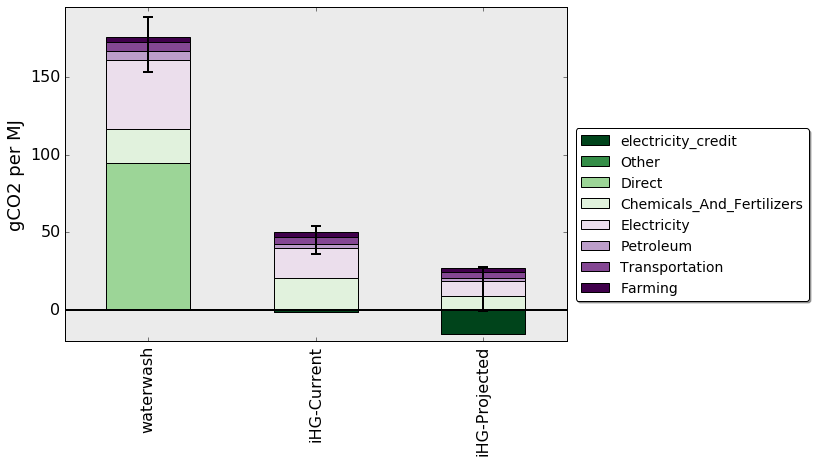

In [31]:
plot = aggregated_data_avg_plot.plot(kind='bar', stacked = True, figsize=(9,6),
                                     colormap='PRGn_r',
                                     yerr={'Farming':plt_errors}, 
                                     error_kw= {'capsize':5, 'ecolor':'k', 'elinewidth':2, 'capthick':2, 'barsabove':True})
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('gCO2 per MJ', fontsize = 18)
plt.ylim(-20,195)
plt.axhline(0, color='black', linewidth=2)
plot.set_axis_bgcolor("#EBEBEB")
plot.legend(loc='lower center', bbox_to_anchor=(1.25, 0.1),ncol=1, fancybox=True, shadow=True,fontsize=14)